# Extract fMRI signal from ROI

In [1]:
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [2]:
%matplotlib inline

We now

 * Preprocessed the raw fMRI data: remove low-frequent noise, motion-correction, etc.
 * (Looked a bit at the behavioral data)
 * Registered the functional data to a standard space

Now we are gonna extract signal from an interesting area: the striatum

### A look at masks

In [3]:
!ls /data/masks

GPe_L.nii.gz  GPi_L.nii.gz  RN_L.nii.gz  SN_L.nii.gz  STh_L.nii.gz  STR_L.nii.gz
GPe_R.nii.gz  GPi_R.nii.gz  RN_R.nii.gz  SN_R.nii.gz  STh_R.nii.gz  STR_R.nii.gz


In [4]:
import nipype.interfaces.fsl as fsl

In [5]:
str_l = nb.load('/data/masks/STR_L.nii.gz').get_data()
mni = nb.load(fsl.Info.standard_image('MNI152_T1_2mm_brain.nii.gz')).get_data()

Now we mask teh values of the mask that are zero

In [6]:
str_l = np.ma.masked_equal(str_l, 0)

Let's find the center of mass of the mask

In [7]:
import scipy as sp
from scipy import ndimage
com = ndimage.center_of_mass(str_l)
com

(36.144952729639087, 64.476695406837607, 37.652531246711284)

All the voxels that are masked are not shown

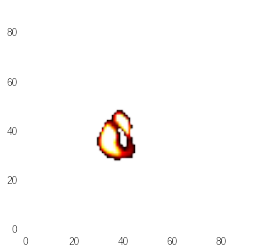

In [8]:
plt.imshow(str_l[:, 64, :].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

Now with MNI

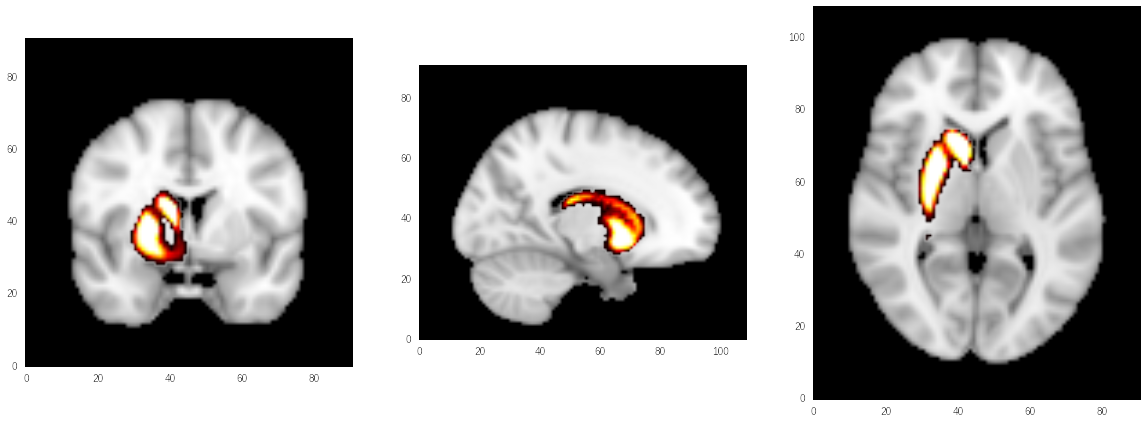

In [9]:
plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(mni[:, 64, :].T,origin='lower', cmap=plt.cm.gray)
plt.imshow(str_l[:, 64, :].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

plt.subplot(132)
plt.imshow(mni[36, :, :].T,origin='lower', cmap=plt.cm.gray)
plt.imshow(str_l[36, :, :].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

plt.subplot(133)
plt.imshow(mni[:, :, 38].T,origin='lower', cmap=plt.cm.gray)
plt.imshow(str_l[:, :, 38].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

1) Can you now also plot the right striatum?

### Extracting the signal

2) Now we have the functional preprocessed data in MNI152-space, we can extract the signal from the mask. Fill in the necessary fields to extract the signal in left striatum form block 1 from subject 197.

In [10]:
extracter = fsl.ImageMeants()
extracter.inputs.in_file = '/data/registration_results/transformed_files/_subject_id_0197/_warpall0/pp0197_B1_dtype_mcf_mask_gms_tempfilt_warp.nii.gz'
extracter.inputs.mask = '/data/masks/STR_L.nii.gz'


Now we can run the interface, and have a look at its results

In [11]:
r = extracter.run()
r.outputs


out_file = /home/summerschool/notebooks/pp0197_B1_dtype_mcf_mask_gms_tempfilt_warp_ts.txt

3) Load the data using np.loadtxt() and then plot the raw signal?

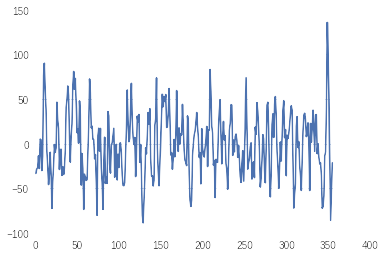

In [12]:
signal = np.loadtxt(r.outputs.out_file)
plt.plot(signal)

4) now also extract the signal from right striatum and plot in the same graph. Notice anything?

In [13]:
extracter = fsl.ImageMeants()
extracter.inputs.in_file = '/data/registration_results/transformed_files/_subject_id_0197/_warpall0/pp0197_B1_dtype_mcf_mask_gms_tempfilt_warp.nii.gz'
extracter.inputs.mask = '/data/masks/STR_R.nii.gz'
r = extracter.run()
r.outputs
signal_r = np.loadtxt(r.outputs.out_file)

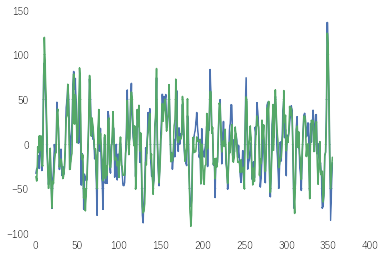

In [14]:
plt.plot(signal)
plt.plot(signal_r)

In [15]:
sp.stats.pearsonr(signal, signal_r)

(0.88685186063211452, 2.0703994276886621e-120)

## Let's pipeline this!

The fsl-interfaces of nipype are nice to quickly have a look at stuff, but if you want to process data systematically, it's good to make a pipeline. You have seen a few before. Let's try to make one ourselves!

In [52]:
import nipype.interfaces.io as nio
import nipype.interfaces.fsl as fsl
import nipype.pipeline.engine as pe

In [53]:
workflow = pe.Workflow(base_dir='/data/workflow_folders/', name='extract_striatum_signal')

Hint: use a asterisk (\*) to "select all files within a directory"

In [54]:
import glob
import os

subject_ids = [os.path.split(fn)[1][2:] for fn in glob.glob('/data/func_raw/*')]
subject_ids

['0498',
 '0544',
 '0538',
 '0553',
 '0552',
 '0197',
 '0549',
 '0551',
 '0559',
 '0558',
 '0471',
 '0483',
 '0554',
 '0548',
 '0523',
 '0372',
 '0381',
 '0555']

In [55]:
templates = {'mask':'/data/masks/{mask}.nii.gz',
            'func':'/data/registration_results/transformed_files/_subject_id_{subject_id}/_warpall*/*.nii.gz'}

selector = pe.Node(nio.SelectFiles(templates), name='selector')

selector.iterables = [('subject_id', subject_ids), ('mask', ['STR_L', 'STR_R'])]

Hint: you probably want to use a [MapNode](http://nipy.sourceforge.net/nipype/users/mapnode_and_iterables.html) here

In [56]:
extracter = pe.MapNode(fsl.ImageMeants(), iterfield=['in_file'], name='extracter')

In [57]:
ds = pe.Node(nio.DataSink(base_directory='/data/extracted_signals'), name='datasink')

In [58]:
workflow.connect(selector, 'mask', extracter, 'mask')
workflow.connect(selector, 'func', extracter, 'in_file')

workflow.connect(extracter, 'out_file', ds, 'extracted_timeseries')

In [59]:
workflow.run(plugin='MultiProc', plugin_args={'n_procs' : 3})

INFO:workflow:['check', 'execution', 'logging']
INFO:workflow:Running in parallel.
INFO:workflow:Submitting 36 jobs
INFO:workflow:Executing: selector.aI.a19 ID: 0
INFO:workflow:Executing: selector.aI.a21 ID: 1
INFO:workflow:Executing: selector.aI.a32 ID: 2
INFO:workflow:Executing: selector.aI.a25 ID: 3
INFO:workflow:Executing: selector.aI.a08 ID: 4
INFO:workflow:Executing: selector.aI.a06 ID: 5
INFO:workflow:Executing node selector.aI.a19 in dir: /data/workflow_folders/extract_striatum_signal/_mask_STR_R_subject_id_0558/selector
INFO:workflow:Executing node selector.aI.a21 in dir: /data/workflow_folders/extract_striatum_signal/_mask_STR_R_subject_id_0471/selector
INFO:workflow:Executing: selector.aI.a27 ID: 6
INFO:workflow:Executing node selector.aI.a32 in dir: /data/workflow_folders/extract_striatum_signal/_mask_STR_L_subject_id_0381/selector
INFO:workflow:Executing: selector.aI.a26 ID: 9
INFO:workflow:Executing: selector.aI.a30 ID: 10
INFO:workflow:Executing: selector.aI.a14 ID: 11
I

5) use the ls command to have a look how the extracted signals look like. Can you plot some?

In [49]:
signal1 = np.loadtxt('/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_0197/_extracter0/pp0197_B1_dtype_mcf_mask_gms_tempfilt_warp_ts.txt')

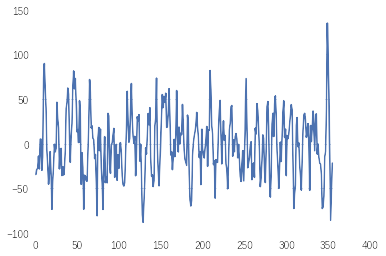

In [55]:
plt.plot(signal1)

## Correlation between brain areas

6) (optional) have a look at sns.corrplot to make correlation plot abo